### Импортим библеотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from python_modules import preprocess
%matplotlib inline
pd.set_option('chained_assignment',None)

### Считываем датасет

In [2]:
import os
datasets = []
for filename in os.listdir("datasets"):
   with open(os.path.join("datasets/", filename), 'r', encoding='utf-8') as f:
       df = pd.read_json(f, encoding='utf-8')
       df['industry'] = [filename for _ in range(df.shape[0])]
       datasets.append(df)


In [3]:
datasets[0].head()

,id,premium,name,department,has_test,response_letter_required,salary,address,employer,snippet,...,working_days,working_time_intervals,working_time_modes,accept_temporary,professional_roles,accept_incomplete_resumes,experience,employment,is_adv_vacancy,industry
0,96701603,False,Младший frontend-разработчик,None,False,False,"{'from': 25000, 'to': 75000, 'currency': 'RUR'...",None,{'trusted': True},{'requirement': 'Базовые знания JavaScript и/и...,...,[],"[{'id': 'from_four_to_six_hours_in_a_day', 'na...","[{'id': 'start_after_sixteen', 'name': 'Можно ...",True,"[{'id': '96', 'name': 'Программист, разработчи...",False,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'part', 'name': 'Частичная занятость'}",False,"industry(Информационные технологии, системная ..."
1,94942479,False,Экономист (специалист по документообороту со з...,None,False,False,"{'from': None, 'to': 145000, 'currency': 'RUR'...","{'city': 'Москва', 'street': 'Северный админис...",{'trusted': True},{'requirement': 'Опыт работы с первичной бухга...,...,[],[],[],False,"[{'id': '142', 'name': 'Экономист'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}",False,"industry(Информационные технологии, системная ..."
2,96610008,False,Game Designer/Геймдизайнер мобильных игр,None,False,False,"{'from': 500, 'to': 1000, 'currency': 'EUR', '...",None,{'trusted': True},{'requirement': 'Хорошее знание мобильных игр....,...,[],[],[],False,"[{'id': '25', 'name': 'Гейм-дизайнер'}]",False,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'full', 'name': 'Полная занятость'}",False,"industry(Информационные технологии, системная ..."
3,96697757,False,SDR - специалист ( Без опыта ),None,False,False,"{'from': 90000, 'to': None, 'currency': 'RUR',...",None,{'trusted': True},{'requirement': 'Навыки поиска актуальной инфо...,...,[],[],[],False,"[{'id': '40', 'name': 'Другое'}]",True,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'full', 'name': 'Полная занятость'}",False,"industry(Информационные технологии, системная ..."
4,96701481,False,Младший backend-разработчик,None,False,False,"{'from': 25000, 'to': 75000, 'currency': 'RUR'...",None,{'trusted': True},{'requirement': 'Базовые знания одного из язык...,...,[],"[{'id': 'from_four_to_six_hours_in_a_day', 'na...","[{'id': 'start_after_sixteen', 'name': 'Можно ...",False,"[{'id': '96', 'name': 'Программист, разработчи...",False,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'part', 'name': 'Частичная занятость'}",False,"industry(Информационные технологии, системная ..."


Теперь надо сделать препроцесс фич и разбить более комплексные фичи на мелкие, так в колонке address есть нужная информация для станций метро.

### Предварительная обработка

In [4]:
for dataset in datasets:
    print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5363 entries, 0 to 5362
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         5363 non-null   int64 
 1   premium                    5363 non-null   bool  
 2   name                       5363 non-null   object
 3   department                 579 non-null    object
 4   has_test                   5363 non-null   bool  
 5   response_letter_required   5363 non-null   bool  
 6   salary                     5363 non-null   object
 7   address                    3288 non-null   object
 8   employer                   5363 non-null   object
 9   snippet                    5363 non-null   object
 10  schedule                   5363 non-null   object
 11  working_days               5363 non-null   object
 12  working_time_intervals     5363 non-null   object
 13  working_time_modes         5363 non-null   object
 14  accept_t

Видно что поле 'department' имеет малое количество вакансий, значит надо избавиться от него. Поля id, name, snippet являются излишними и не нужными в анализе и обучении модели

In [5]:
for dataset in datasets:
    dataset.drop(columns=["department", "id", "name", "snippet"], inplace=True)

In [6]:
datasets[0].head()

,premium,has_test,response_letter_required,salary,address,employer,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,professional_roles,accept_incomplete_resumes,experience,employment,is_adv_vacancy,industry
0,False,False,False,"{'from': 25000, 'to': 75000, 'currency': 'RUR'...",None,{'trusted': True},"{'id': 'remote', 'name': 'Удаленная работа'}",[],"[{'id': 'from_four_to_six_hours_in_a_day', 'na...","[{'id': 'start_after_sixteen', 'name': 'Можно ...",True,"[{'id': '96', 'name': 'Программист, разработчи...",False,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'part', 'name': 'Частичная занятость'}",False,"industry(Информационные технологии, системная ..."
1,False,False,False,"{'from': None, 'to': 145000, 'currency': 'RUR'...","{'city': 'Москва', 'street': 'Северный админис...",{'trusted': True},"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,"[{'id': '142', 'name': 'Экономист'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}",False,"industry(Информационные технологии, системная ..."
2,False,False,False,"{'from': 500, 'to': 1000, 'currency': 'EUR', '...",None,{'trusted': True},"{'id': 'remote', 'name': 'Удаленная работа'}",[],[],[],False,"[{'id': '25', 'name': 'Гейм-дизайнер'}]",False,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'full', 'name': 'Полная занятость'}",False,"industry(Информационные технологии, системная ..."
3,False,False,False,"{'from': 90000, 'to': None, 'currency': 'RUR',...",None,{'trusted': True},"{'id': 'remote', 'name': 'Удаленная работа'}",[],[],[],False,"[{'id': '40', 'name': 'Другое'}]",True,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'full', 'name': 'Полная занятость'}",False,"industry(Информационные технологии, системная ..."
4,False,False,False,"{'from': 25000, 'to': 75000, 'currency': 'RUR'...",None,{'trusted': True},"{'id': 'remote', 'name': 'Удаленная работа'}",[],"[{'id': 'from_four_to_six_hours_in_a_day', 'na...","[{'id': 'start_after_sixteen', 'name': 'Можно ...",False,"[{'id': '96', 'name': 'Программист, разработчи...",False,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'part', 'name': 'Частичная занятость'}",False,"industry(Информационные технологии, системная ..."


In [7]:
# упрощение столбцов и сохранение атомарных признаков
for dataset in datasets:
    dataset["salary"] = dataset["salary"].apply(preprocess.get_net_salary)
    dataset["schedule"] = dataset["schedule"].apply(lambda x: x["name"])
    dataset["experience"] = dataset["experience"].apply(lambda x: x["name"])
    dataset["employment"] = dataset["employment"].apply(lambda x: x["name"])
    dataset["employer"] = dataset["employer"].apply(lambda x: x["trusted"])
    dataset.rename(columns={"employer": "trusted_employer"}, inplace=True)
    dataset["industry"] = dataset["industry"].apply(lambda x: x[9:-6])

In [8]:
# считывание станций метро в Москве
stations = np.load("src_files/stations.npy")

In [9]:
# получение признаков из адреса: долгота, широта, количество ближайших станций и расстояние до ближайшей станции.
for dataset in datasets:
    dataset[["stations_within_km", "distance_to_the_nearest(m)"]] = dataset["address"].apply(lambda x: pd.Series(preprocess.get_stations_count_and_distance_to_nearest(x, stations)))
    dataset[["lat", "lon"]] = dataset["address"].apply(lambda x: pd.Series((x["lat"], x["lng"]) if x is not None else (None, None)))

In [10]:
# удаление адреса и профессиональных ролей, так как они теперь избыточны.
for dataset in datasets:
    dataset.drop(columns=["address"], inplace=True)
    dataset.drop(columns=["professional_roles"], inplace=True)

In [11]:
datasets[0].head()

,premium,has_test,response_letter_required,salary,trusted_employer,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,accept_incomplete_resumes,experience,employment,is_adv_vacancy,industry,stations_within_km,distance_to_the_nearest(m),lat,lon
0,False,False,False,50000.0,True,Удаленная работа,[],"[{'id': 'from_four_to_six_hours_in_a_day', 'na...","[{'id': 'start_after_sixteen', 'name': 'Можно ...",True,False,Нет опыта,Частичная занятость,False,"Информационные технологии, системная интеграци...",NaN,NaN,NaN,NaN
1,False,False,False,145000.0,True,Полный день,[],[],[],False,False,От 1 года до 3 лет,Полная занятость,False,"Информационные технологии, системная интеграци...",2.0,528.369614,55.800863,37.554717
2,False,False,False,652.5,True,Удаленная работа,[],[],[],False,False,Нет опыта,Полная занятость,False,"Информационные технологии, системная интеграци...",NaN,NaN,NaN,NaN
3,False,False,False,90000.0,True,Удаленная работа,[],[],[],False,True,Нет опыта,Полная занятость,False,"Информационные технологии, системная интеграци...",NaN,NaN,NaN,NaN
4,False,False,False,50000.0,True,Удаленная работа,[],"[{'id': 'from_four_to_six_hours_in_a_day', 'na...","[{'id': 'start_after_sixteen', 'name': 'Можно ...",False,False,Нет опыта,Частичная занятость,False,"Информационные технологии, системная интеграци...",NaN,NaN,NaN,NaN


Есть 3 колонки которые могут быть очень полезны для анализа, но достаточно ли там непустых значений?

In [12]:
datasets[0]["working_days"].value_counts()

working_days
[]                                                                          5296
[{'id': 'only_saturday_and_sunday', 'name': 'Работа только по сб и вс'}]      67
Name: count, dtype: int64

In [13]:
datasets[0]["working_time_intervals"].value_counts()

working_time_intervals
[]                                                                                                   5122
[{'id': 'from_four_to_six_hours_in_a_day', 'name': 'Можно работать сменами по 4–6 часов в день'}]     241
Name: count, dtype: int64

In [14]:
datasets[0]["working_time_modes"].value_counts()

working_time_modes
[]                                                                                5154
[{'id': 'start_after_sixteen', 'name': 'Можно начинать работать после 16:00'}]     209
Name: count, dtype: int64

Большинство не имеет данного описания, удаляем эти колонки

In [15]:
# удаление трех столбцов, так как они в основном состоят из пустых значений.
for dataset in datasets:
    dataset.drop(columns=["working_time_modes", "working_time_intervals", "working_days"], inplace=True)

In [16]:
datasets[0].head()

,premium,has_test,response_letter_required,salary,trusted_employer,schedule,accept_temporary,accept_incomplete_resumes,experience,employment,is_adv_vacancy,industry,stations_within_km,distance_to_the_nearest(m),lat,lon
0,False,False,False,50000.0,True,Удаленная работа,True,False,Нет опыта,Частичная занятость,False,"Информационные технологии, системная интеграци...",NaN,NaN,NaN,NaN
1,False,False,False,145000.0,True,Полный день,False,False,От 1 года до 3 лет,Полная занятость,False,"Информационные технологии, системная интеграци...",2.0,528.369614,55.800863,37.554717
2,False,False,False,652.5,True,Удаленная работа,False,False,Нет опыта,Полная занятость,False,"Информационные технологии, системная интеграци...",NaN,NaN,NaN,NaN
3,False,False,False,90000.0,True,Удаленная работа,False,True,Нет опыта,Полная занятость,False,"Информационные технологии, системная интеграци...",NaN,NaN,NaN,NaN
4,False,False,False,50000.0,True,Удаленная работа,False,False,Нет опыта,Частичная занятость,False,"Информационные технологии, системная интеграци...",NaN,NaN,NaN,NaN


В нашем датасете присутствуют вакансии, у которых либо отсутствует адрес, либо они находятся за пределами административных районов Москвы. Однако стоит учитывать, что некоторые из этих вакансий предназначены для удаленной работы, поэтому отсутствие офиса не является необычным явлением. Следовательно, мы должны сохранить такие вакансии в датасете, поскольку жители Москвы вполне могут подавать на них заявки и работать удаленно.

https://habr.com/ru/companies/ods/articles/338554/

Ресурс помог в визуализации средних зарплат по административным районам Москвы

In [17]:
# получение GeoPandas DataFrame с административными округами Москвы.
mo_gdf = gpd.read_file('src_files/atd/mo.shp')
mo_gdf.head()

,NAME,OKATO,OKTMO,NAME_AO,OKATO_AO,ABBREV_AO,TYPE_MO,geometry
0,Киевский,45298555,45945000,Троицкий,45298000,Троицкий,Поселение,"MULTIPOLYGON (((36.80310 55.44083, 36.80319 55..."
1,Филёвский Парк,45268595,45328000,Западный,45268000,ЗАО,Муниципальный округ,"POLYGON ((37.42765 55.74821, 37.42849 55.74875..."
2,Новофёдоровское,45298567,45954000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.80357 55.45162, 36.80451 55.46551..."
3,Роговское,45298575,45956000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.93724 55.24139, 36.93726 55.24161..."
4,"""Мосрентген""",45297568,45953000,Новомосковский,45297000,Новомосковский,Поселение,"POLYGON ((37.43956 55.62731, 37.44018 55.63042..."


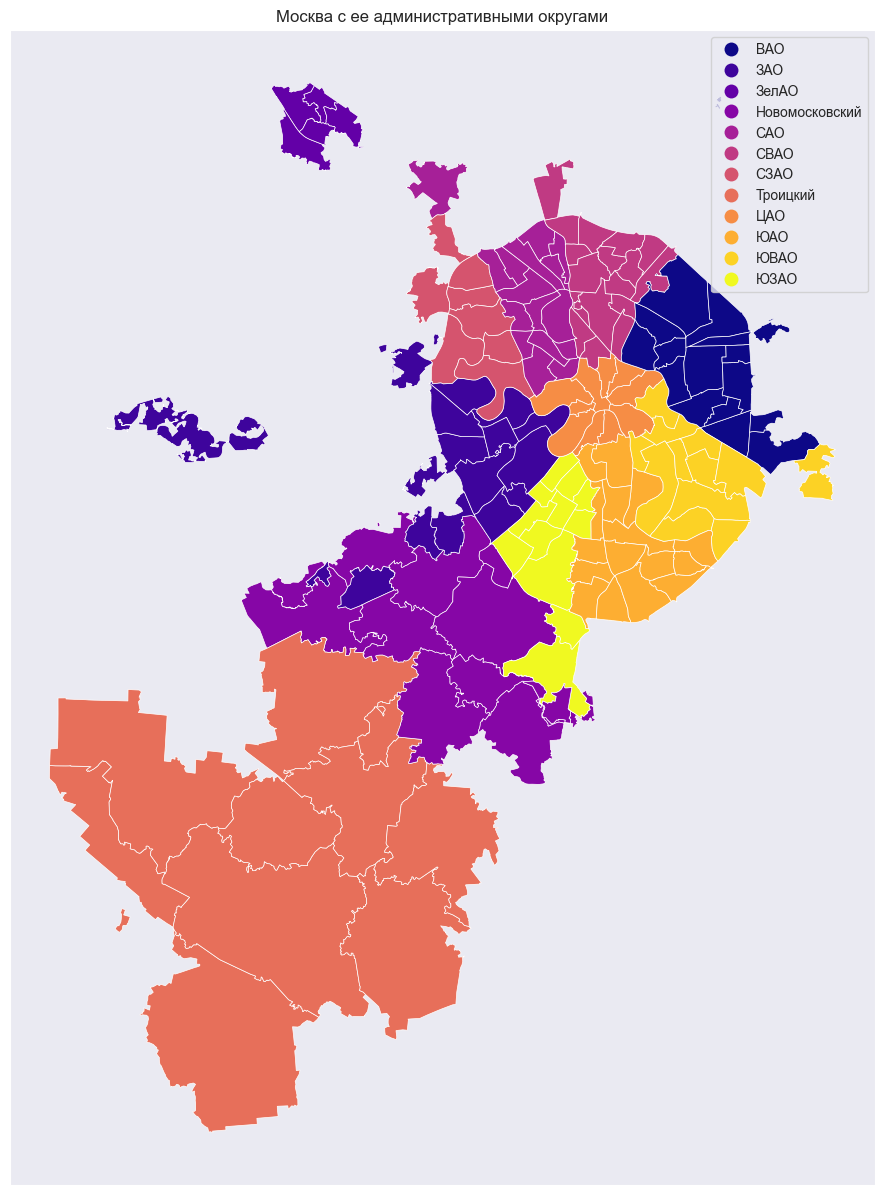

In [18]:
# показать Москву с ее административными округами.
mo_gdf_wm = mo_gdf.to_crs(epsg='3857')
mo_gdf_wm.plot(column = 'ABBREV_AO', linewidth=0.5, cmap='plasma', legend=True, figsize=[15,15])
plt.xticks([])
plt.yticks([])
plt.title("Москва с ее административными округами")
plt.show()

In [19]:
# определяем автономный район в котором находится офис компании, выставившей вакансию, в случае вне Москвы ставим "Не в Москве"
for dataset in datasets:
    dataset["AO"] = dataset[["lat", "lon"]].apply(lambda row: preprocess.find_AO(row, mo_gdf), axis=1)

In [20]:
# оставить только вакансии из Москвы или с удаленной работой в графике.
in_moscow_or_remote = []
for dataset in datasets:
    filtered_dataset = dataset.loc[(dataset["AO"] != "Не в Москве") | (dataset["schedule"] == "Удаленная работа")]
    in_moscow_or_remote.append(filtered_dataset.reset_index(drop=True))


In [21]:
in_moscow_or_remote[0].describe()

,salary,stations_within_km,distance_to_the_nearest(m),lat,lon
count,4064.000000,2880.000000,2880.000000,2915.000000,2915.000000
mean,115712.221077,2.589931,659.337073,55.717981,37.670831
std,80351.031335,2.373197,758.254746,0.465880,2.881018
min,200.000000,0.000000,0.000000,43.609818,-79.431292
25%,65000.000000,1.000000,325.844776,55.706883,37.540075
50%,90000.000000,2.000000,555.481688,55.749633,37.604655
75%,150000.000000,4.000000,818.230265,55.790504,37.654727
max,775000.000000,12.000000,16108.234903,59.945477,104.329484


In [22]:
for dataset in in_moscow_or_remote:
    print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4064 entries, 0 to 4063
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   premium                     4064 non-null   bool   
 1   has_test                    4064 non-null   bool   
 2   response_letter_required    4064 non-null   bool   
 3   salary                      4064 non-null   float64
 4   trusted_employer            4064 non-null   bool   
 5   schedule                    4064 non-null   object 
 6   accept_temporary            4064 non-null   bool   
 7   accept_incomplete_resumes   4064 non-null   bool   
 8   experience                  4064 non-null   object 
 9   employment                  4064 non-null   object 
 10  is_adv_vacancy              4064 non-null   bool   
 11  industry                    4064 non-null   object 
 12  stations_within_km          2880 non-null   float64
 13  distance_to_the_nearest(m)  2880 

Я имею 7 bool колонок, 5 скалярные колонки и 5 категориальные

Для заполнения пустых значений в столбцах stations_within_km, distance_to_the_nearest(m) возьму моду и медиану соотвественно.

In [23]:
# заполнение пустых ячеек фрейма
for dataset in in_moscow_or_remote:
    dataset["lat"] = dataset["lat"].fillna(dataset["lat"].median())
    dataset["lon"] = dataset["lon"].fillna(dataset["lon"].median())
    dataset["stations_within_km"] = dataset["stations_within_km"].fillna(dataset["stations_within_km"].mode().iloc[0])
    dataset["distance_to_the_nearest(m)"] = dataset["distance_to_the_nearest(m)"].fillna(dataset["distance_to_the_nearest(m)"].median())

In [24]:
in_moscow_or_remote[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4064 entries, 0 to 4063
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   premium                     4064 non-null   bool   
 1   has_test                    4064 non-null   bool   
 2   response_letter_required    4064 non-null   bool   
 3   salary                      4064 non-null   float64
 4   trusted_employer            4064 non-null   bool   
 5   schedule                    4064 non-null   object 
 6   accept_temporary            4064 non-null   bool   
 7   accept_incomplete_resumes   4064 non-null   bool   
 8   experience                  4064 non-null   object 
 9   employment                  4064 non-null   object 
 10  is_adv_vacancy              4064 non-null   bool   
 11  industry                    4064 non-null   object 
 12  stations_within_km          4064 non-null   float64
 13  distance_to_the_nearest(m)  4064 

### EDA и визуал

Для понимания основных тенденций надо исключить выбросы, так например один бухгалтер с зарплатой 85 млн может помешать увидеть закономерности в графике зарплат

<img alt="Alt text" height="800" src="images\outlier_example.jpg" width="1000"/>{}

In [25]:
# удаление выбросов, чтобы они не влияли на визуализацию.
dataset_without_outliers = []
for dataset in in_moscow_or_remote:
    q_low = dataset["salary"].quantile(0.025)
    q_hi  = dataset["salary"].quantile(0.975)
    dataset_without_outliers.append(dataset[(dataset["salary"] < q_hi) & (dataset["salary"] > q_low)].reset_index(drop=True))
    

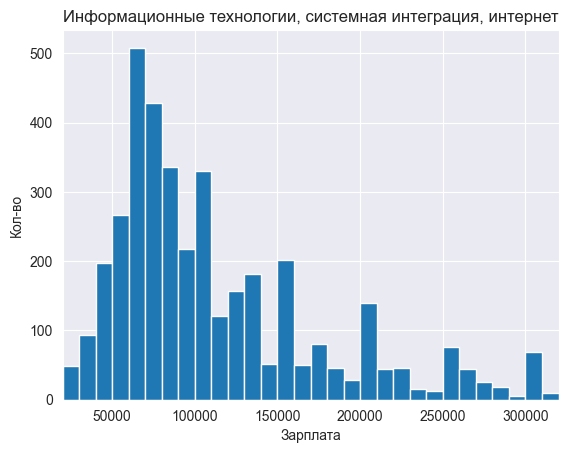

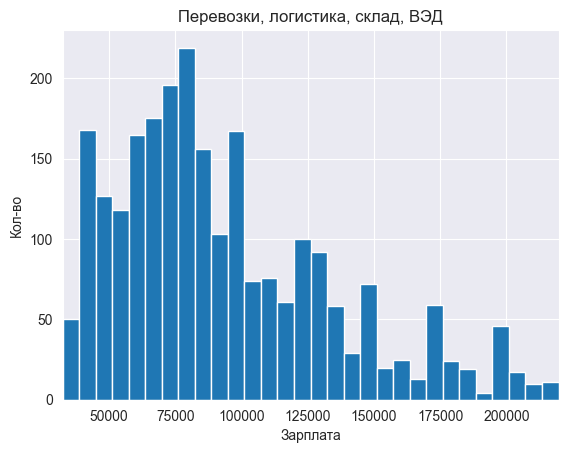

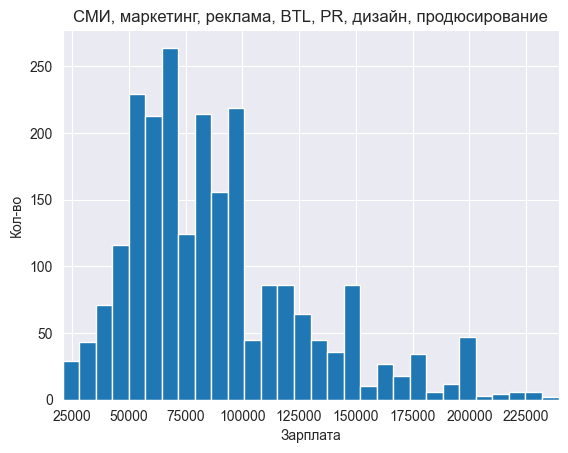

In [26]:
# построить гистограммы зарплат для каждой отрасли.
for dataset in dataset_without_outliers:
    plt.hist(dataset["salary"], 30)
    plt.title(dataset["industry"][0])
    plt.xlim((dataset["salary"].min(), dataset["salary"].max()))
    plt.xlabel("Зарплата")
    plt.ylabel("Кол-во")
    plt.show()

Видно, что графики слегка отличаются. Для более достоверного результата, можно проверить одинаковые ли зарплаты для работников разных отраслей с помощью статистических техник.

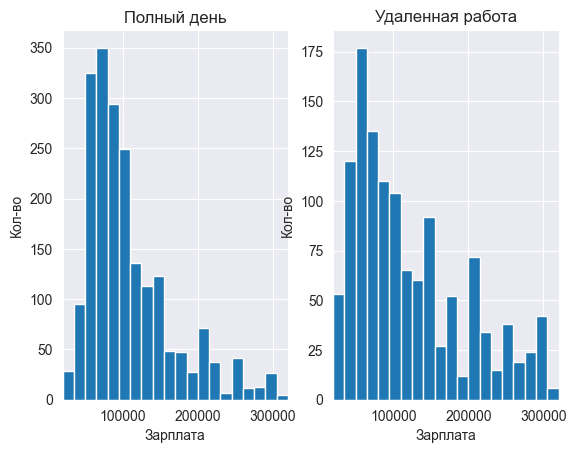

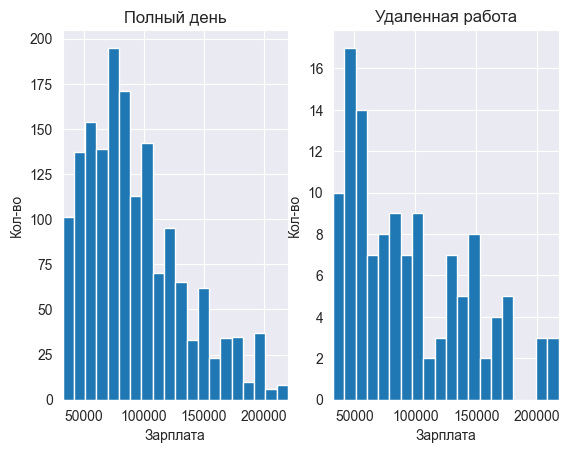

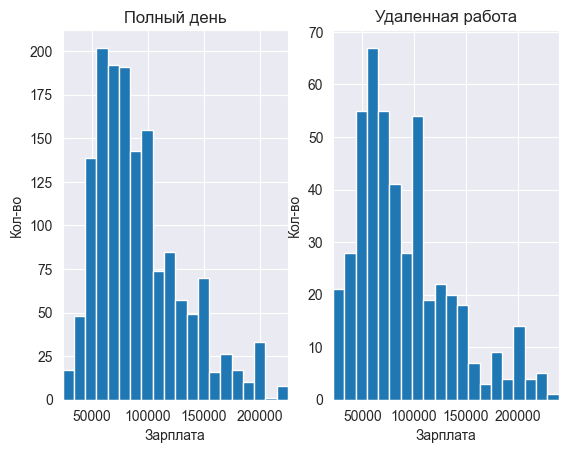

In [27]:
for dataset in dataset_without_outliers:
    in_office = dataset.loc[dataset["schedule"] == "Полный день", "salary"]
    out_office = dataset.loc[dataset["schedule"] == "Удаленная работа", "salary"]
    ax, fig = plt.subplots(ncols=2)
    fig[0].hist(in_office, 20)
    fig[0].set_title("Полный день")
    fig[0].set_xlim((in_office.min(), in_office.max()))
    fig[0].set_xlabel("Зарплата")
    fig[0].set_ylabel("Кол-во")
    fig[1].hist(out_office, 20)
    fig[1].set_title("Удаленная работа")
    fig[1].set_xlim((out_office.min(), out_office.max()))
    fig[1].set_xlabel("Зарплата")
    fig[1].set_ylabel("Кол-во")
    plt.show()

По графикам неочевидно, есть ли отличие между распределением зарплат тех, кто работает полный день в офисе и теми кто не делает так. Различия на графиках могут быть обусловлены особенностями выборки вакансий, поэтому статистический анализ необходим для более точного определения существующих различий или их отсутствия между заработными платами удаленных работников и тех, кто работает в офисе на полный рабочий день.

In [28]:
dataset_without_outliers[0]["AO"].value_counts()

AO
Не в Москве       1047
ЦАО                770
ЮАО                368
САО                312
СВАО               290
ЗАО                245
ВАО                223
ЮЗАО               185
ЮВАО               179
СЗАО               144
Новомосковский      81
Троицкий             6
ЗелАО                3
Name: count, dtype: int64

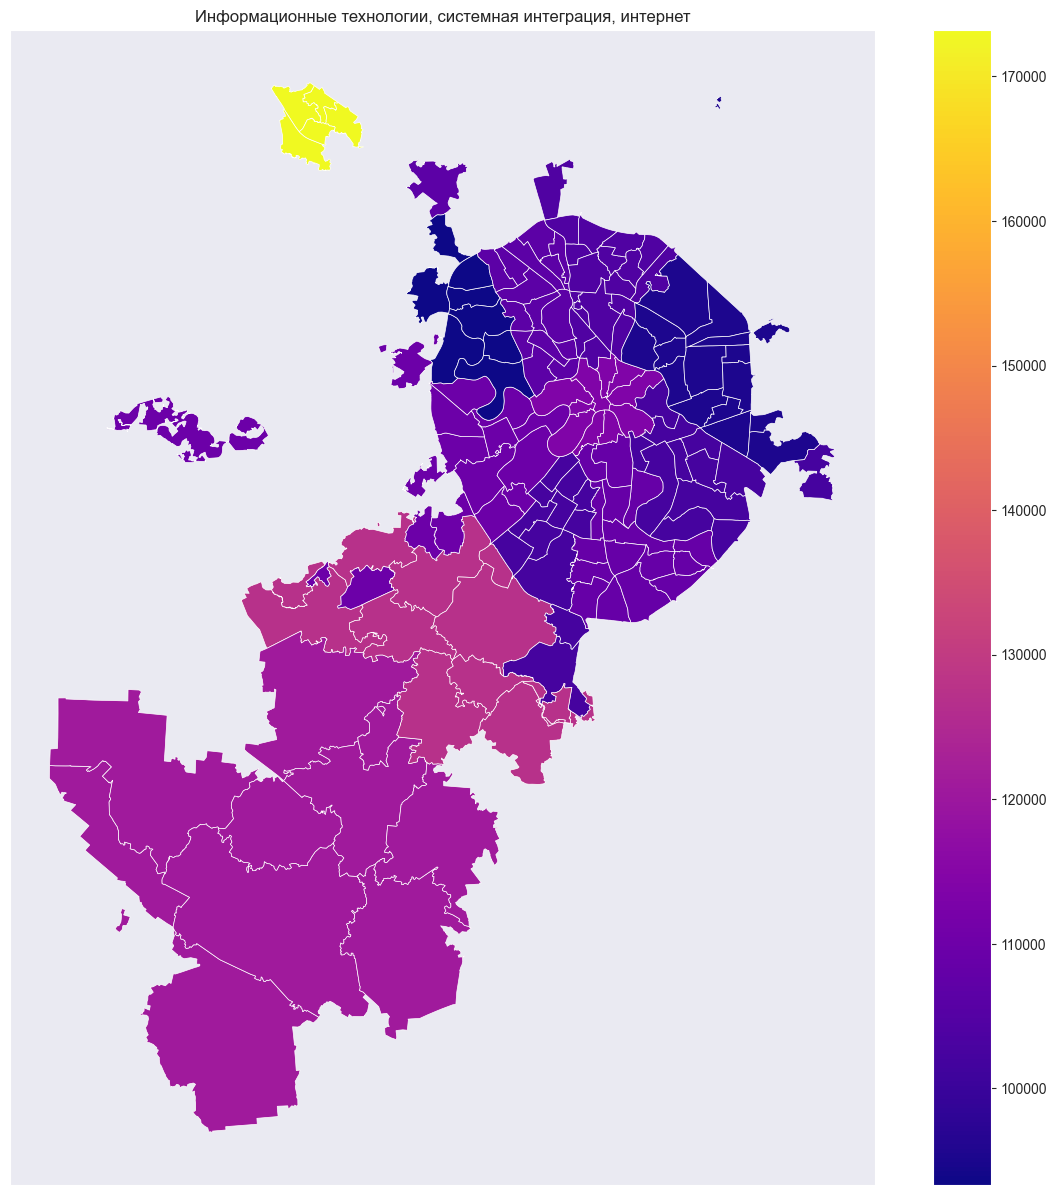

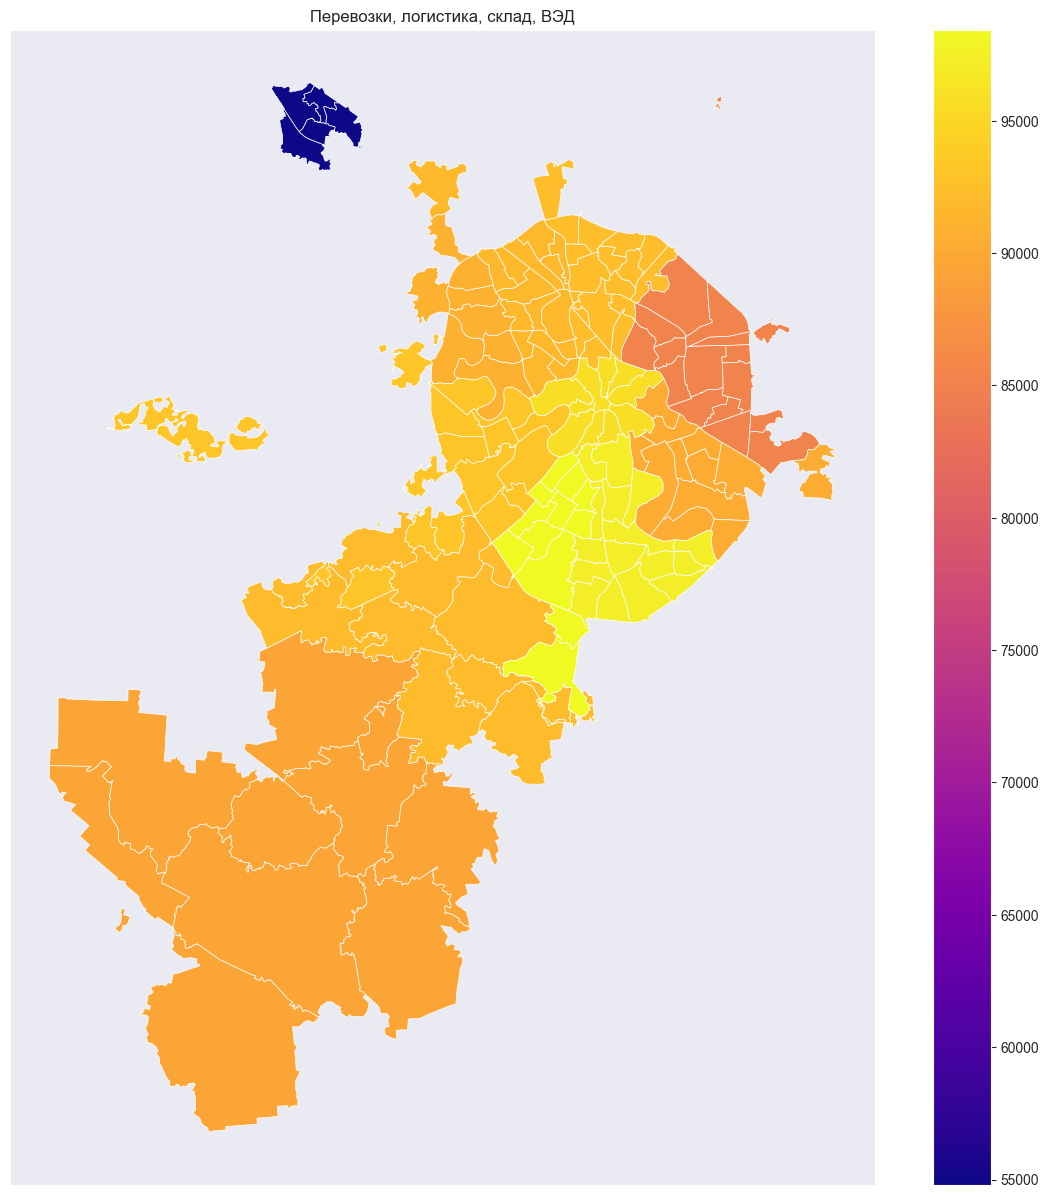

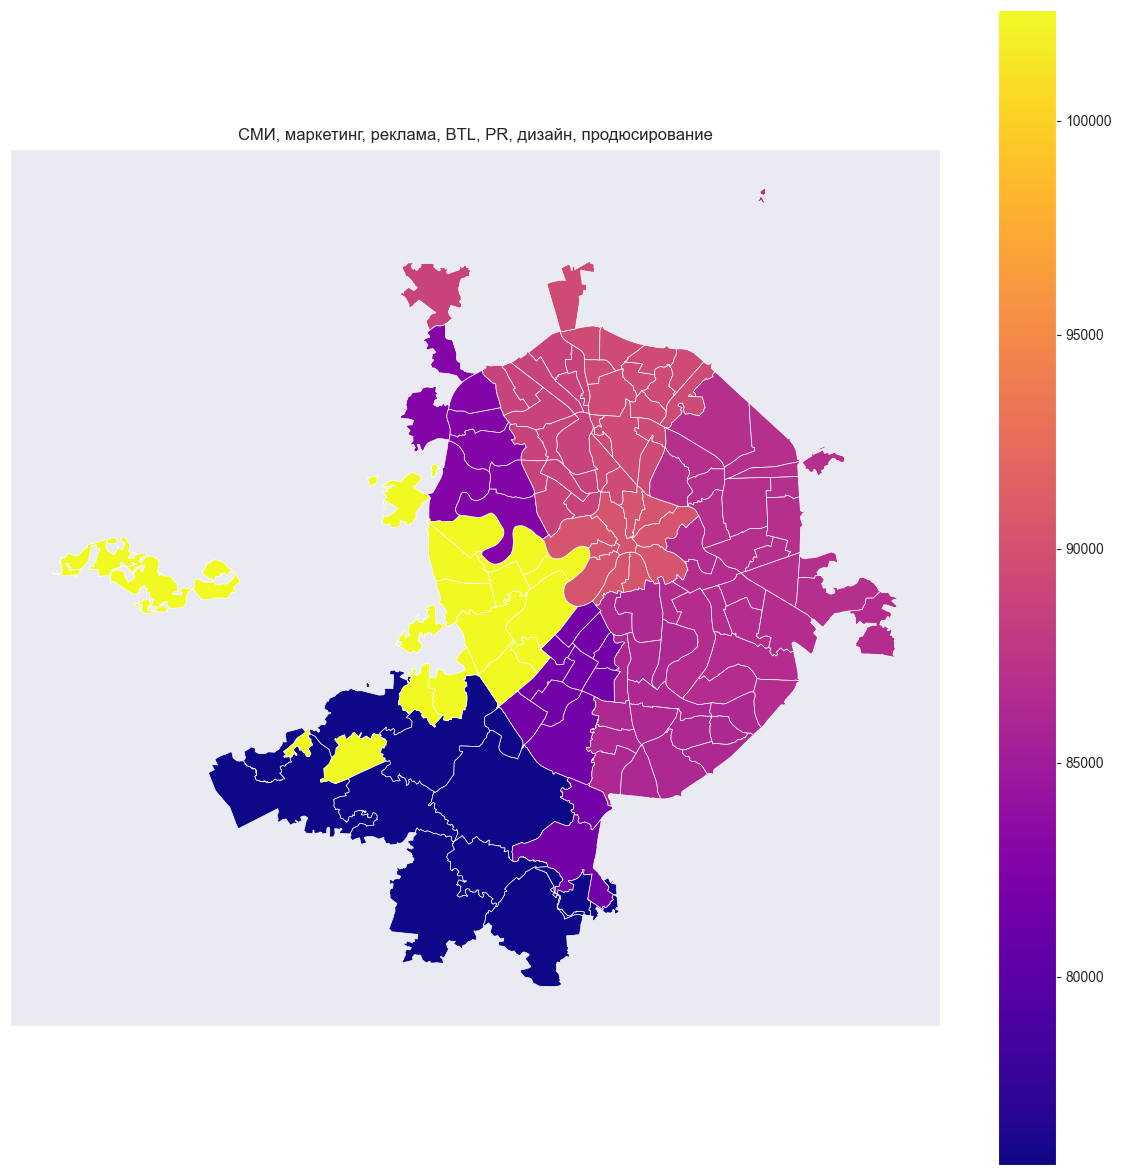

In [29]:
for dataset in dataset_without_outliers:
    adm_districts_avg_salaries = {
    "ЦАО": 0,
    "ЮАО": 0,
    "ЮВАО": 0,
    "САО": 0,
    "ЗАО": 0,
    "СВАО": 0,
    "ВАО": 0,
    "Новомосковский": 0,
    "ЮЗАО": 0,
    "СЗАО": 0,
    "ЗелАО": 0,
    "Троицкий": 0,
    "Не в Москве": 0
    }
    for ao in adm_districts_avg_salaries.keys():
        adm_districts_avg_salaries[ao] = dataset.loc[dataset["AO"] == ao, "salary"].mean()
    df_to_salary = mo_gdf[["ABBREV_AO", "geometry"]]
    df_to_salary["avg_salary"] = pd.Series(df_to_salary["ABBREV_AO"].apply(lambda x: adm_districts_avg_salaries[x]))
    salaries = df_to_salary.to_crs(epsg='3857') #непосредственно преобразование проекции
    salaries.plot(column = 'avg_salary', linewidth=0.5, cmap='plasma', legend=True, figsize=[15,15])
    plt.title(dataset["industry"][0])
    plt.xticks([])
    plt.yticks([])
    plt.show()

Зарплата в Москве может отличаться в разных районах и по разным видам работы. Например, в центре города или в IT-сфере она обычно выше, чем в спальных районах или в сфере обслуживания. Поэтому, чтобы понять, сколько можно заработать, нужно учитывать как район, так и вид работы. Так мы можем получить более точную картину и сделать правильные выводы о зарплате в Москве.

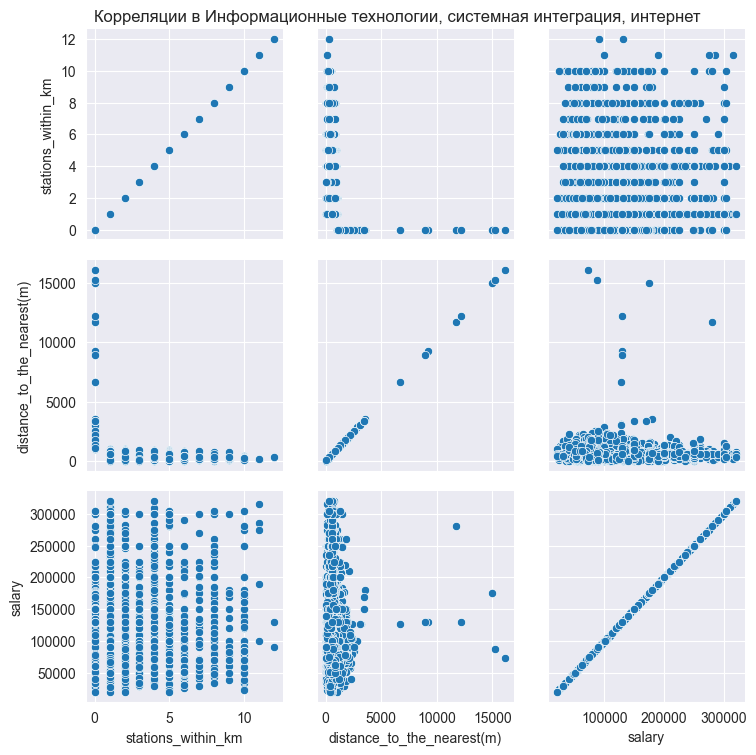

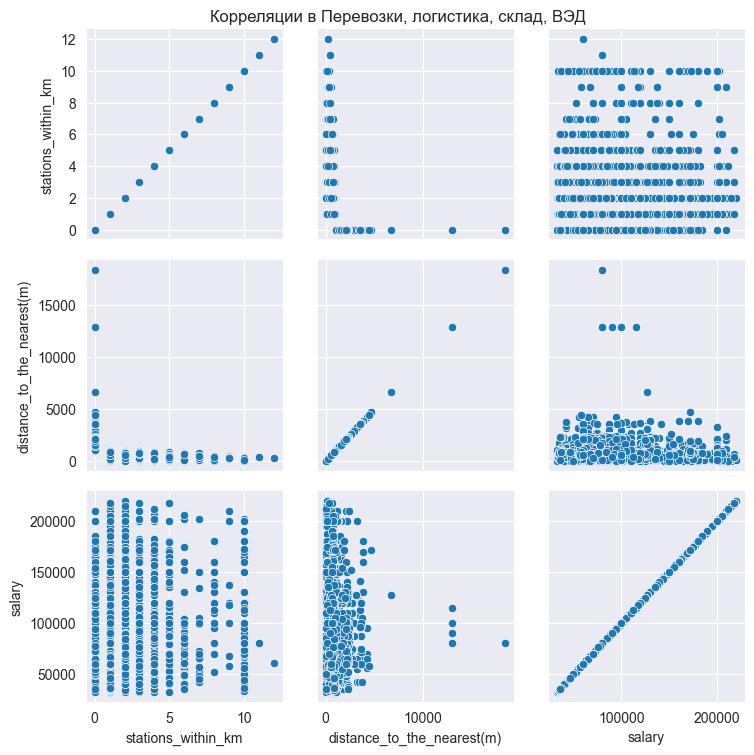

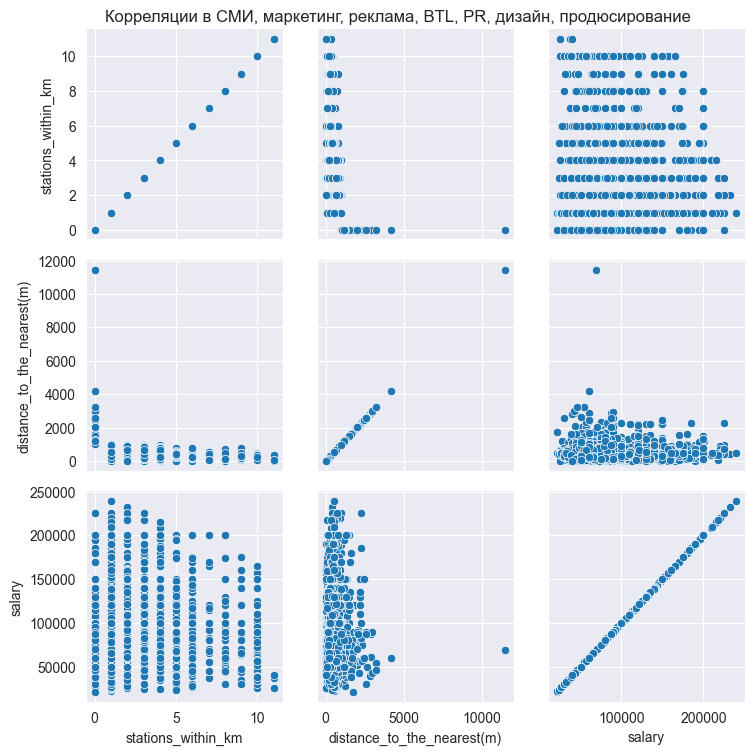

In [30]:
# ищем корреляцию между кол-вом станций, расстоянием до ближайшей станции и зарплатой, используя PairGrid
for dataset in dataset_without_outliers:
    industry = dataset["industry"][0]
    
    pg = sns.PairGrid(dataset[["stations_within_km", "distance_to_the_nearest(m)", "salary"]])
    pg.figure.suptitle(f"Корреляции в {industry}", y=1)
    pg.map(sns.scatterplot)
    

Отсутствие заметной корреляции может быть объяснено тем, что мы не наблюдаем определенного паттерна точек на графике, который бы указывал на сильную связь между параметрами. В основном, вакансии имеют значение расстояния от 0 до 2000 метров от ближайшей станции, но это скорее связано с тем, какие вакансии входили в выборку, чем с реальной зависимостью. Если в радиусе 1 км нет метро, то ближайшая станция может быть далеко, что кажется логичным.

Теперь можно посмотреть, люди с каким опытом требуются в разные индустрии. И зависит ли зарплата от опыта работы? Скорее всего зависит, но это нужно проверить.

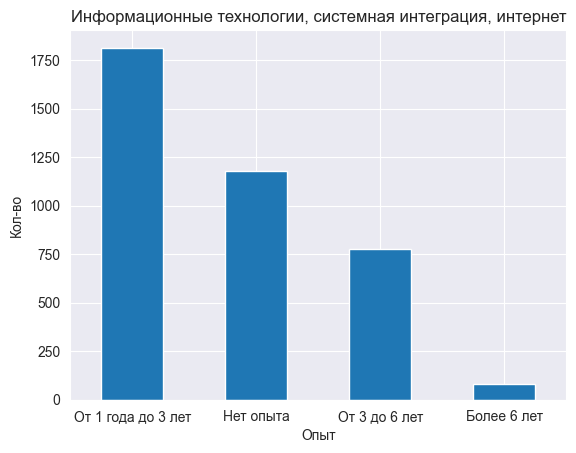

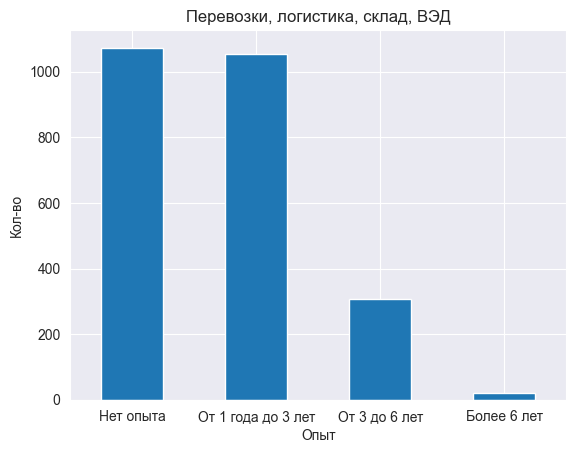

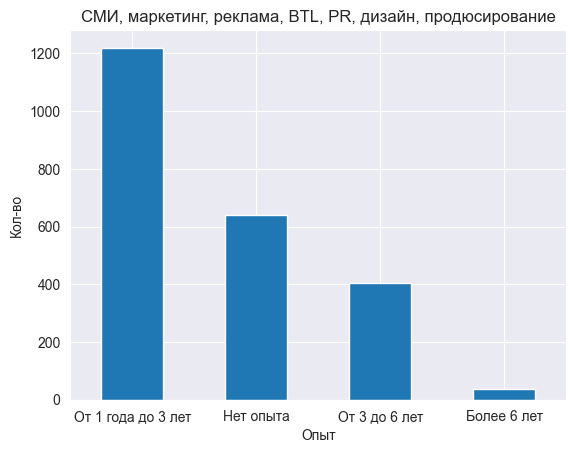

In [31]:
for dataset in dataset_without_outliers:
    exp = {
        "Нет опыта": 0,
        "От 1 года до 3 лет": 0,
        "От 3 до 6 лет": 0,
        "Более 6 лет": 0
    }
    dataset["experience"].value_counts().plot.bar(rot=0)
    plt.title(dataset["industry"][0])
    plt.ylabel("Кол-во")
    plt.xlabel("Опыт")
    plt.show()

По распределению столбцов видно, что большинство вакансий расчитаны на опыт от 1 года до 3 лет, но в других индустриях может быть по-другому, так в перевозках 

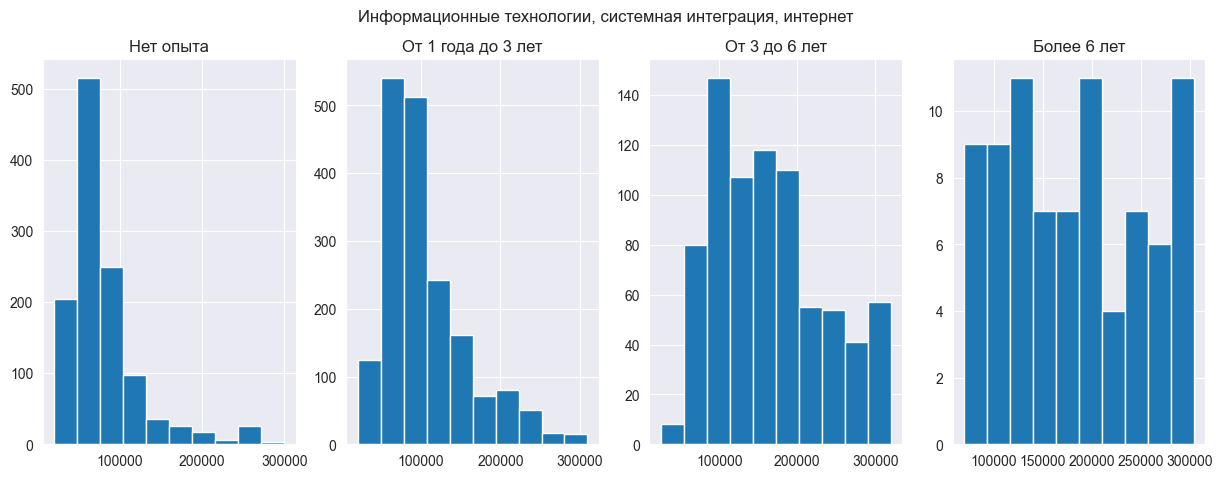

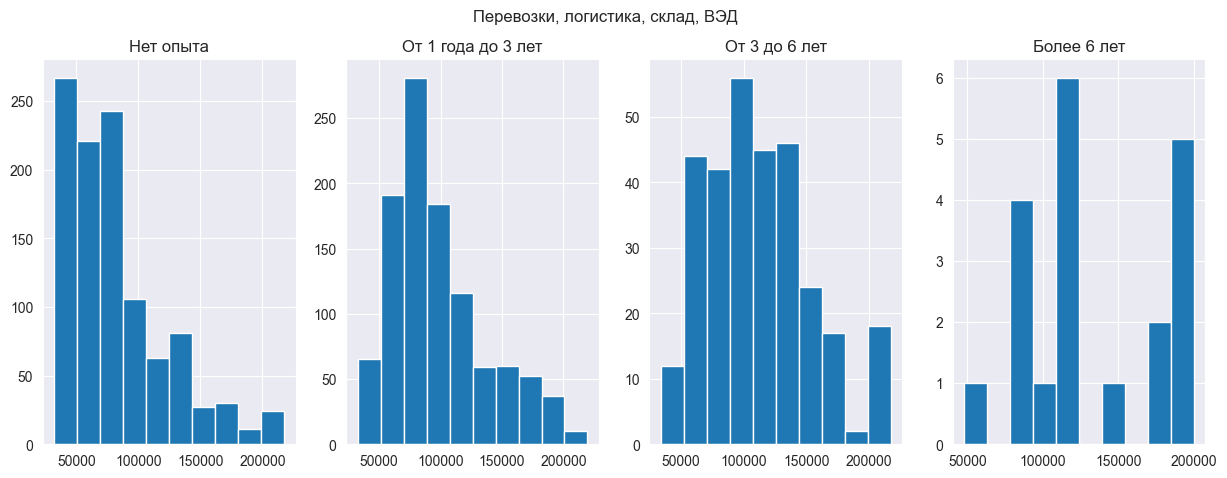

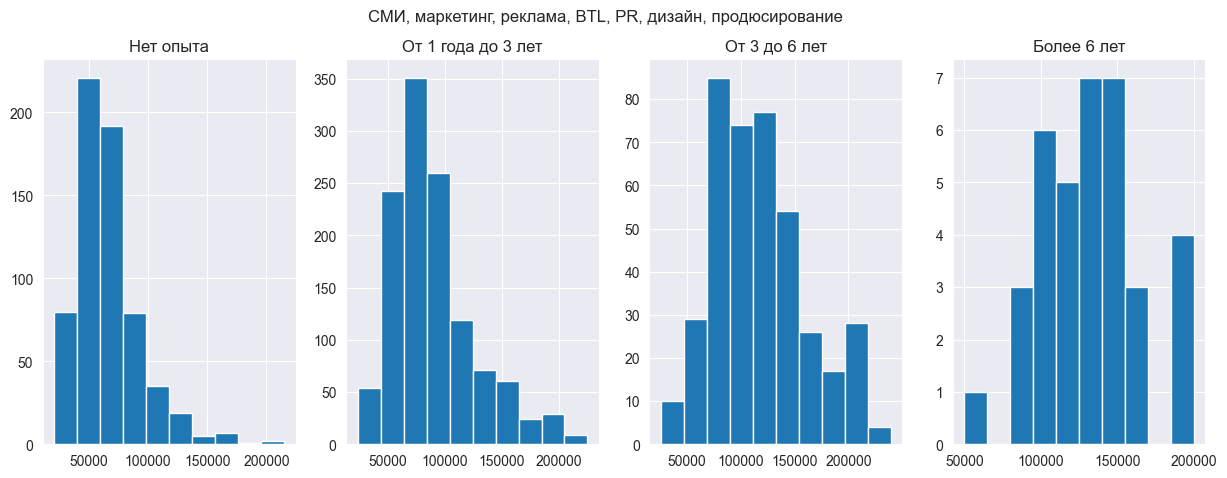

In [32]:
for dataset in dataset_without_outliers:
    _, fig = plt.subplots(ncols=4, figsize=[15,5])
    for i, exp in enumerate(["Нет опыта", "От 1 года до 3 лет", "От 3 до 6 лет", "Более 6 лет"]):
        fig[i].hist(dataset.loc[dataset["experience"]==exp, "salary"], label=exp)
        fig[i].set_title(exp)
    plt.suptitle(dataset["industry"][0])
    plt.show()

Видно,что есть тенденция к увеличению средней зарплаты с большим опытом. Притом в Информационных технологиях и СМИ-маркетинге такая тенденция сохраняется. А в электронике категории 3-6 лет опыта и от 6 лет опыта примерно одинаковые зарплаты.

Булевские переменные

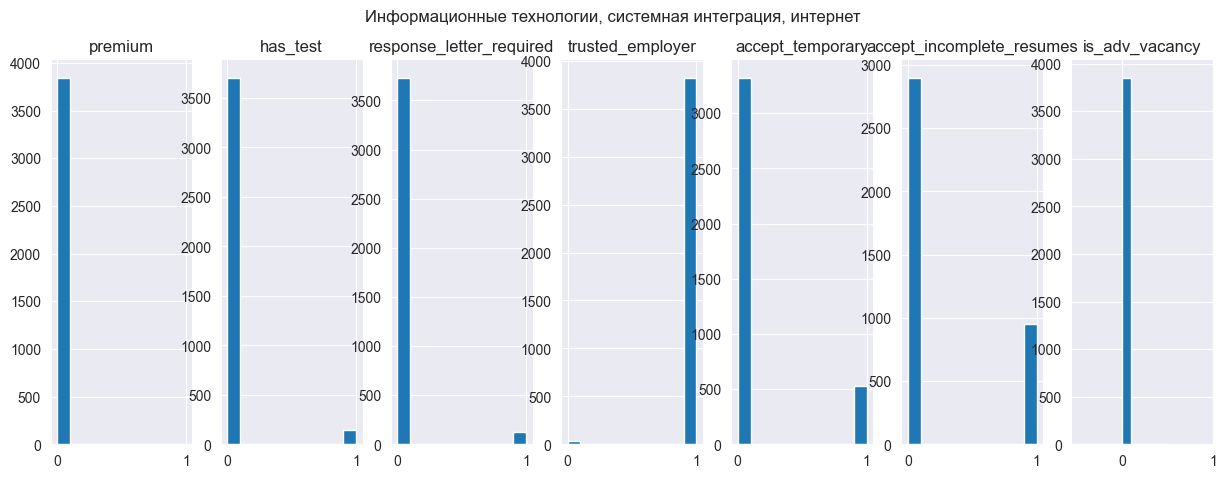

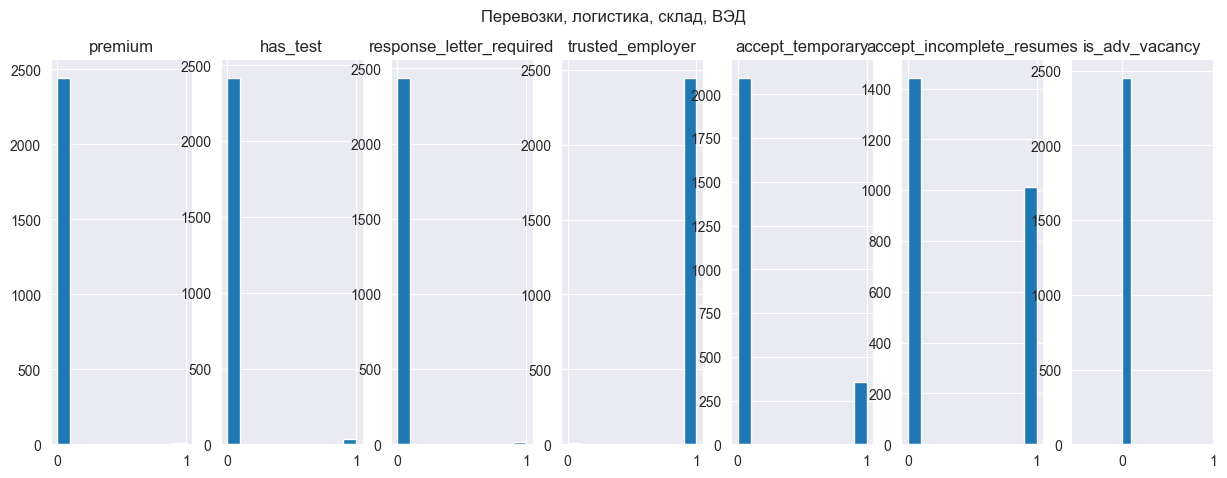

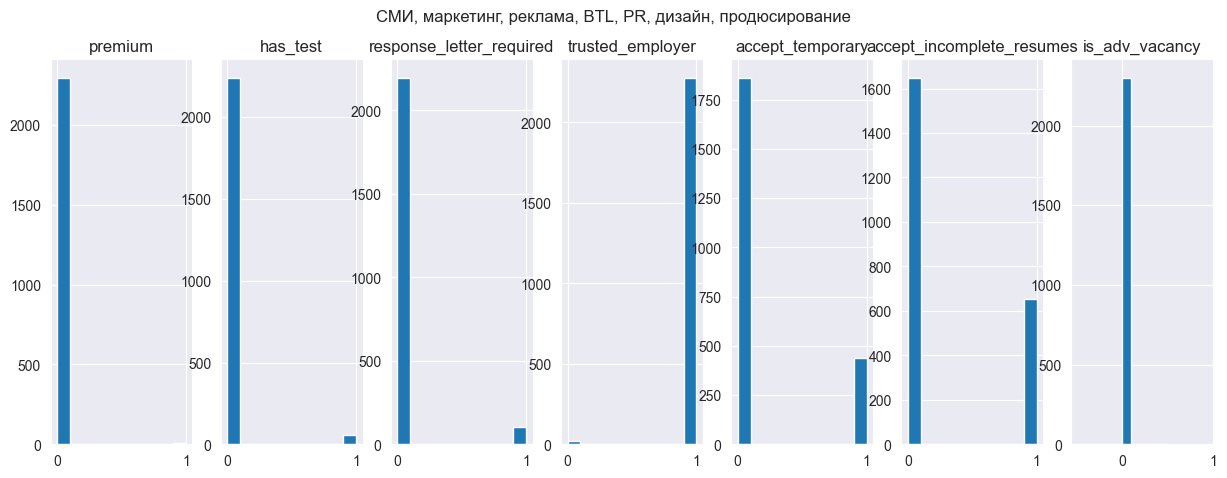

In [33]:
bool_cols = []
for col in dataset_without_outliers[0].columns:
    if dataset_without_outliers[0][col].dtype == bool:
        bool_cols.append(col)
for dataset in dataset_without_outliers:
    _, fig = plt.subplots(ncols=len(bool_cols), figsize=[15,5])
    for i, col in enumerate(bool_cols):
        fig[i].hist(dataset[col].apply(lambda x: 1 if x else 0))
        fig[i].set_xticks([0, 1])
        fig[i].set_title(col)
    plt.suptitle(dataset["industry"][0])
    plt.show()

Как видно из графиков большинство булевских переменных не сбалансированы, недостаточно наблюдений, чтобы будущая модель по этим параметрам умела предсказывать нужную зарплату на вакансию. В ходе статистического анализа надо проверить значимость этих параметров на итоговую зарплату. В случае, когда данные являются незначительными, следует удалить данные колонки во избежании ошибок в прогнозировании.

Последняя колонка для рассмотрения это employment

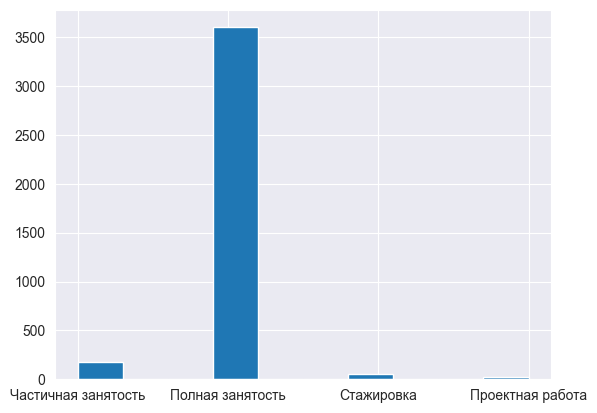

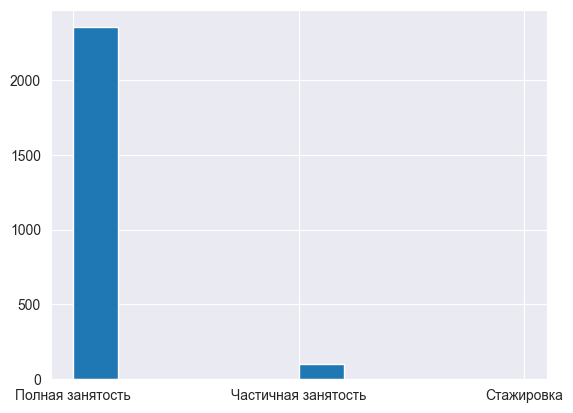

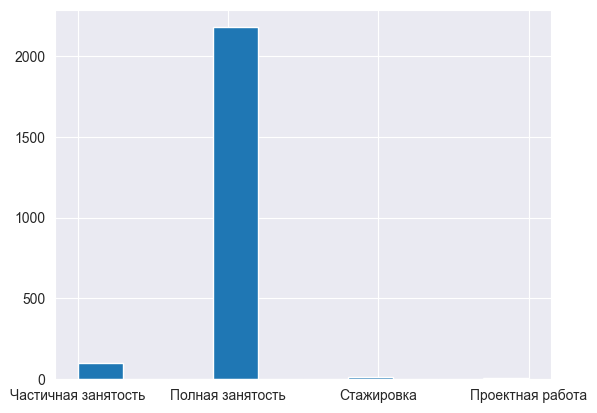

In [34]:
for dataset in dataset_without_outliers:
    plt.hist(dataset["employment"])
    plt.show()

Как видно большая часть вакансий ориентирована на полную занятость. Вероятно, придется объединить более редко встречающиеся типы занятости в "Другое".

### Статистический анализ